## Classification Model with Linear Model

In [168]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [3]:
from fastai import *
from fastai.text import *

In [4]:
torch.cuda.set_device(3)
torch.cuda.current_device()

3

In [5]:
import parse_inputs

from pathlib import Path

import numpy as np
import pandas as pd
from pandas_plink import read_plink

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn import metrics

#from ggplot import *
PATH=Path('ddat/crowdAI/')
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn import linear_model
#import crowdai

In [8]:
import random

In [9]:
from snp2h import *

/home/ahmadA/anaconda3/envs/dereck/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Loading Genotype and Phenotype

In [160]:
?read_plink

In [169]:
import vcf

In [170]:
vcf_reader = vcf.Reader(filename='ddat/crowdAI/alltaizhou.vcf.gz')

In [172]:
import pysam

In [175]:
from pysam import VCF

vcf = VCF()
vcf.connect('ddat/crowdAI/alltaizhou.vcf.gz')

for record in vcf.fetch('5'):
    print(record)

OSError: index `ddat/crowdAI/alltaizhou.vcf.gz.tbi` not found

In [173]:
for record in vcf_reader.fetch('20', 1110695, 1230237):  
     print(record)

Exception: pysam not available, try "pip install pysam"?

In [10]:
tz_plink = read_plink('ddat/crowdAI/all2964/bin_final_strand')
tz_maf = pd.read_csv(PATH/'TZ14_one.frq',delim_whitespace=True)
all_meta = pd.read_csv(TMP_PATH/'tz_and_os_meta.csv',index_col=0)
all_meta.head()

Mapping files: 100%|██████████| 3/3 [00:01<00:00,  1.15it/s]


,ID,height,ChipID,nationality,gender,biclass,triclass,residual
9992564090_R01C01,TL2257,177.0,9992564090_R01C01,0,1,1,1,8.606139
9992564090_R05C01,TL0067,155.0,9992564090_R05C01,0,2,0,0,-1.518641
9992564090_R07C01,TL0139,143.5,9992564090_R07C01,0,2,0,-1,-13.018641
9992564090_R08C01,TL0279,161.9,9992564090_R08C01,0,2,1,1,5.381359
9992564137_R01C01,TL1090,155.2,9992564137_R01C01,0,2,0,0,-1.318641


In [11]:
pcs = pd.read_csv(PATH/'all2964/tz_plink_ld_r2_0.2.eigenvec',delim_whitespace=True,header=None,usecols=range(1,6),index_col=0)

In [12]:
pcs.columns = ['pc1','pc2','pc3','pc4']

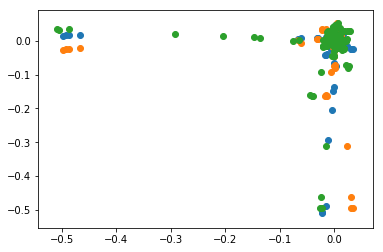

In [13]:
plt.scatter(pcs.pc1,pcs.pc2)
plt.scatter(pcs.pc1,pcs.pc3)
plt.scatter(pcs.pc2,pcs.pc3)

In [112]:
i = -0.1
sum(pcs.pc1< i),sum(pcs.pc2<i),sum(pcs.pc3<i),sum(pcs.pc4<i),sum((pcs<i).sum(1)==0)

(4, 7, 7, 4, 2946)

In [81]:
import numpy as np

def removeOutliers(x, outlierConstant=1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
    return resultList

In [84]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

In [88]:
sum(percentile_based_outlier(np.array(pcs.pc3)))

150

In [83]:
len(removeOutliers(np.array(pcs.pc1)))

2914

(array([   3.,    0.,    0.,    1.,    3.,    0.,    1.,    0., 2887.,   69.]),
 array([-0.47656, -0.42243, -0.3683 , -0.31418, -0.26005, -0.20593, -0.1518 , -0.09768, -0.04355,  0.01057,
         0.0647 ]),
 <a list of 10 Patch objects>)

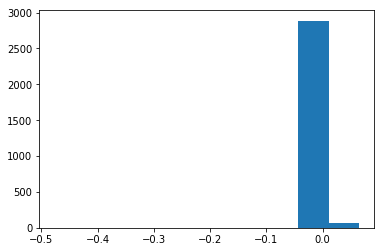

In [80]:
plt.hist(pcs.pc4)

In [69]:
pcs.head()

,pc1,pc2,pc3,pc4
1,,,,
9992564090_R01C01,-0.002153,0.005162,-0.009551,0.001801
9992564090_R02C01,-0.000760,0.001298,0.000205,0.006244
9992564090_R04C01,0.001983,0.005145,0.000541,0.005650
9992564090_R05C01,-0.000875,0.003965,0.000334,-0.003586
9992564090_R06C01,0.002148,-0.000913,0.003487,-0.001595


In [21]:
import plotly

In [25]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np
plotly.offline.init_notebook_mode(connected=True)

x, y, z,c = pcs.iloc[:,2],pcs.iloc[:,3],pcs.iloc[:,4],(pcs.iloc[:,0]!='HAN').astype(int)

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=c,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='3d-scatter-colorscale')

/home/ahmadA/anaconda3/envs/fastai/lib/python3.6/site-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `3d-scatter-colorscale` didn't end with .html. Adding .html to the end of your file.



'file:///home/ahmadA/dereck/proj/predict_height/3d-scatter-colorscale.html'

# Filter genotype  

In [13]:
tz_maf_filter = tz_maf.apply(select_snp, axis=1)
tz_maf_new=tz_maf.loc[tz_maf_filter==1,]
tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(all_meta.index)]
tz_plink=plink_slice(tz_plink,list(tz_maf_new.index),tz_sample_index)

# Get GWAS 

In [14]:
snps = {'tz_a':pd.read_csv(TMP_PATH/'SNPs_GWAS_Pincrease_Residual_of_Gender.csv',index_col=0),
       'tz_f':pd.read_csv(TMP_PATH/'SNPs_GWAS_TZ_Female.csv',index_col=0),
       'tz_m':pd.read_csv(TMP_PATH/'SNPs_GWAS_TZ_Male.csv',index_col=0),
       'os_a':pd.read_csv(TMP_PATH/'SNPs_GWAS_Pincrease_Residual_of_Gender_OS.csv',index_col=0),
       'os_f':pd.read_csv(TMP_PATH/'SNPs_GWAS_OS_Female.csv',index_col=0),
       'os_m':pd.read_csv(TMP_PATH/'SNPs_GWAS_OS_Male.csv',index_col=0),
       'other':pd.read_csv(TMP_PATH/'snps_sorted_p_val_v2.csv',index_col=0)}

In [15]:
snp_pool = set(tz_plink[0].snp)
len(snp_pool)

684066

In [16]:
def topn_snp(s,p,t=500):
    n = 0
    snp = []
    for x in s.index:
        if x in p:
            n +=1
            snp.append(x)
            if n>=t:
                break
    return snp

In [17]:
snp_list=[{k:topn_snp(v,snp_pool,t=n) for k,v in snps.items()} for n in [50,100,200,300,500]]

# Linear model (gender and nationality)

In [40]:
def gn_residual(meta,test=None,t=True,col=['gender','nationality']):
    #Load training data
    x_train = meta[col]
    y_train = meta.height

    # Instantiate a linear model
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    if t:
        x_test = test[col]
        # Predict the heights for the test set
        heights = regr.predict(x_test)
        submit(heights)
    return regr

In [18]:
tz_meta=all_meta.loc[tz_plink[1].iid,]

In [19]:
tz_meta.head()

,ID,height,ChipID,nationality,gender,biclass,triclass,residual
9992564090_R01C01,TL2257,177.0,9992564090_R01C01,0,1,1,1,8.606139
9992564090_R05C01,TL0067,155.0,9992564090_R05C01,0,2,0,0,-1.518641
9992564090_R07C01,TL0139,143.5,9992564090_R07C01,0,2,0,-1,-13.018641
9992564090_R08C01,TL0279,161.9,9992564090_R08C01,0,2,1,1,5.381359
9992564137_R01C01,TL1090,155.2,9992564137_R01C01,0,2,0,0,-1.318641


In [20]:
def pre_data(meta,snp,tz_plink):

    tz_snp_index = [i for i,x in enumerate(tz_plink[0].snp) if x in snp]
    tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(meta.index)]
    tz_sub=plink_slice(tz_plink,tz_snp_index,tz_sample_index)
    
    all_bim = tz_sub[0]
    all_fam = tz_sub[1]
    all_bed_T= pd.DataFrame(tz_sub[2].compute()).T
    all_bed_T.fillna(1,inplace=True)
    all_bed_T.index = list(all_fam.iid)
    all_bed_T.columns=list(all_bim.snp)
    print(all_bim.shape,all_fam.shape,all_bed_T.shape)
    
    X = all_bed_T
    y = meta
    
    return X,y

In [180]:
?np.random.sample

In [264]:
snp_rdn50=list(np.random.choice(tz_plink[0].snp,50))

In [362]:
geno,meta = pre_data(tz_meta,snp_list[4]['tz_a'],tz_plink)
#geno,meta = pre_data(tz_meta,snp_rdn50,tz_plink)

(500, 7) (2747, 7) (2747, 500)


In [364]:
geno = np.array(geno)

In [373]:
geno = geno[:,:484]

In [374]:
geno_onehot = (np.arange(geno.max()+1)==geno[...,None]).astype(int)

In [376]:
geno_onehot = geno_onehot.transpose((0,2,1))

In [378]:
geno_onehot = geno_onehot.reshape((2747,3,22,22))

In [379]:
geno_onehot.shape

(2747, 3, 22, 22)

In [380]:
geno_onehot

array([[[[0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 1, 1, 1, ..., 0, 0, 0, 0],
         ...,
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [1, 1, 0, 1, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 1, 0, ..., 0, 0, 0, 0]],

        [[1, 1, 1, 1, ..., 0, 0, 0, 0],
         [0, 1, 1, 0, ..., 0, 1, 1, 1],
         [1, 1, 1, 1, ..., 1, 1, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         ...,
         [1, 0, 0, 1, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 1, 0],
         [0, 0, 0, 1, ..., 0, 0, 0, 0]],

        [[0, 0, 0, 0, ..., 1, 1, 1, 1],
         [1, 0, 0, 1, ..., 1, 0, 0, 0],
         [0, 0, 0, 0, ..., 0, 0, 1, 1],
         [1, 0, 0, 0, ..., 1, 1, 1, 1],
         ...,
         [0, 1, 1, 0, ..., 1, 1, 1, 1],
         [0, 0, 1, 0, ..., 1, 1, 1, 1],
         [1, 1, 1, 1, ..., 1, 1, 0, 1],
         [1, 1, 0, 0, ..., 1, 1, 1

In [371]:
np.sqrt(500)

22.360679774997898

In [243]:
def shuffle(df, n=1, axis=0):     
    df = df.copy()
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
    return df

In [289]:
geno = shuffle(geno)

In [423]:
len(tz_maf)

795597

In [290]:
geno.head()

,rs10788950,rs4949766,kgp1335101,rs4652800,rs2483064,rs476557,rs7533588,kgp5221295,rs11683654,rs6721624,...,rs6494801,rs4792592,rs7215199,rs6503800,rs7359564,kgp9356372,kgp1476762,rs2233679,kgp10023174,kgp22816540
9992564090_R01C01,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,...,2.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,1.0,1.0
9992564090_R05C01,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0
9992564090_R07C01,2.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,...,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0
9992564090_R08C01,2.0,1.0,0.0,1.0,2.0,0.0,1.0,2.0,2.0,1.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
9992564137_R01C01,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0


In [312]:
pca = PCA(.95)
genp=pd.DataFrame(pca.fit_transform(geno))

In [313]:
genp.shape

(2747, 25)

## Dataset

In [381]:
from torch.utils.data import Dataset

In [382]:
class GPArrDataset(Dataset):
    def __init__(self,x,y):
        self.x,self.y = x,y
        
    
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        g,p = self.x[index],self.y[index]
        return np.float32(g),np.float32(p)

In [397]:
from sklearn.preprocessing import scale

In [384]:
def norm0t1(m,low,high):
    return (m - low)/(high-low)

def norm_arr(arr):
    v_min = np.min(arr)
    v_max = np.max(arr)
    return (norm0t1(arr,v_min,v_max)-0.5)*2

In [385]:
def norm_mat(x):
    x_normed = (x - x.min(0)) / x.ptp(0)
    return (x_normed - 0.5)*2

In [398]:
#vtx = np.hstack((np.array(genp),np.array(meta[['gender']]),np.array(pcs.loc[tz_plink[1].iid,])))
#vtx = np.hstack((np.array(genp),np.array(meta[['gender']])))
#vtx = np.array(pcs.loc[tz_plink[1].iid,])
#vtx = np.array(genp)
vtx = geno_onehot
kps = np.array(meta[['height']]).reshape(2747)
#vtx = norm_mat(vtx)
kps = scale(kps)

In [401]:
np.random.seed(0)
rd_idx= np.random.choice(range(2747),2747,replace=False)
trn_idx,val_idx = np.sort(rd_idx[:2000]),np.sort(rd_idx[2000:])
trn_idx,val_idx

trn_ds,vld_ds = GPArrDataset(vtx[trn_idx],kps[trn_idx]),GPArrDataset(vtx[val_idx],kps[val_idx])

data = DataBunch.create(trn_ds,vld_ds,bs=64,num_workers=1)

In [402]:
data.one_batch()[0].shape

torch.Size([64, 3, 22, 22])

## Model

In [413]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [389]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name,nc,sigmoid=False,channel=3):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name],channel)
        self.classifier = nn.Sequential(nn.Linear(512,nc),nn.Sigmoid()) if sigmoid else nn.Linear(512, nc) 

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg, in_channels):
        layers = []
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AdaptiveAvgPool2d((1,1))]
        return nn.Sequential(*layers)

In [354]:
from torch import nn

class Net(nn.Module):                 
    def __init__(self):
        super(Net, self).__init__()   
        self.fc1 = nn.Linear(4,64) 
        self.relu1 = nn.ReLU(True)
        self.fc2 = nn.Linear(64,64)
        self.relu2 = nn.ReLU(True)
        self.fc3 = nn.Linear(64,32)
        self.relu3 = nn.ReLU(True)
        self.fc4 = nn.Linear(32,1)
        self.dp = nn.Dropout(0.4)
        
    def forward(self, input):
            output = input.view(-1, 4)
            output = self.fc1(output)
            output = self.relu1(output)
            output = self.dp(output)
            output = self.fc2(output)
            output = self.relu2(output)
            output = self.dp(output)
            output = self.fc3(output)
            output = self.relu3(output)
            output = self.fc4(output)
            return output

In [414]:
#model = VGG('VGG11',1)
model = ResNet18()
learn = Learner(data,model,loss_func=nn.MSELoss())

In [415]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


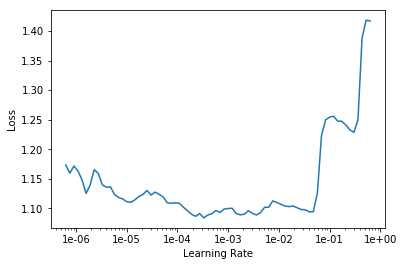

In [416]:
learn.recorder.plot()

In [417]:
learn.fit_one_cycle(5,max_lr=0.01)

epoch,train_loss,valid_loss,time
0,1.093929,1.058889,00:02
1,1.075603,1.052180,00:02
2,1.035193,1.065534,00:02
3,1.012353,1.051841,00:02
4,0.998774,1.059322,00:02


In [418]:
learn.fit_one_cycle(10,max_lr=0.01)

epoch,train_loss,valid_loss,time
0,0.995095,1.051987,00:02
1,1.009934,1.057273,00:02
2,0.997294,1.057841,00:02
3,0.996913,1.051713,00:02
4,0.988907,1.055882,00:02
5,0.983719,1.051818,00:02
6,0.981853,1.052296,00:02
7,0.979439,1.052173,00:02
8,0.984681,1.051755,00:02
9,0.979449,1.051811,00:02


In [345]:
learn.load("fcc_height_stage1")

RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for fc1.weight: copying a param with shape torch.Size([256, 26]) from checkpoint, the shape in current model is torch.Size([64, 25]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([256, 256]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([32, 64]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for fc4.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([1, 32]).

In [176]:
?learn.get_preds

In [419]:
preds,y,losses = learn.get_preds(with_loss=True)

In [342]:
from scipy.stats.stats import pearsonr

In [420]:
np.corrcoef(list(preds.numpy().reshape(-1,)),list(y.numpy().reshape(-1,)))

array([[1.      , 0.023038],
       [0.023038, 1.      ]])

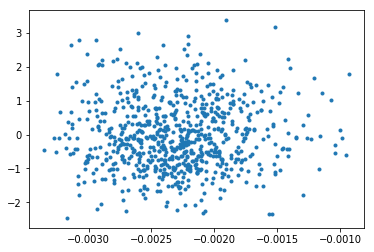

In [421]:
plt.plot(preds,y,'.')

In [153]:
learn.save("fcc_height_stage1")

In [77]:
learn.fit_one_cycle(100,max_lr=0.001)

epoch,train_loss,valid_loss,time
0,0.028414,0.030515,00:01
1,0.028465,0.030519,00:00
2,0.028503,0.030519,00:00
3,0.028359,0.030517,00:00
4,0.028344,0.030510,00:00
5,0.028459,0.030517,00:00
6,0.028471,0.030529,00:00
7,0.028482,0.030514,00:01
8,0.028565,0.030510,00:00
9,0.028540,0.030540,00:00


# Remove outliers

In [130]:
tz_meta_row = tz_meta

In [140]:
tz_meta=tz_meta_row.loc[(tz_meta_row[['pc1','pc2','pc3','pc4']]< -0.005).sum(1)==0,:]

In [141]:
regr = gn_residual(tz_meta,t=False,col=['gender','nationality','pc1','pc2','pc3','pc4'])

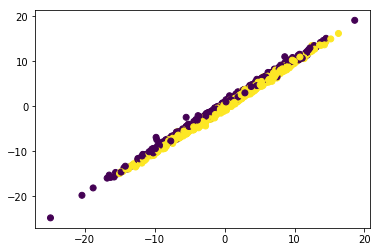

In [142]:
plt.scatter(tz_meta.residual,tz_meta.height-regr.predict(tz_meta[['gender','nationality','pc1','pc2','pc3','pc4']]),c=tz_meta.gender)

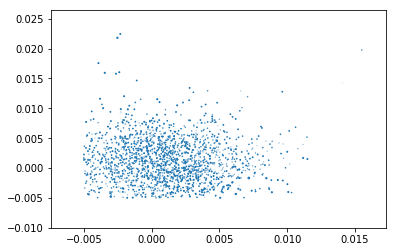

In [143]:
plt.scatter(tz_meta.pc1,tz_meta.pc2,s=(tz_meta.residual-(tz_meta.height-regr.predict(tz_meta[['gender','nationality','pc1','pc2','pc3','pc4']]))).abs())

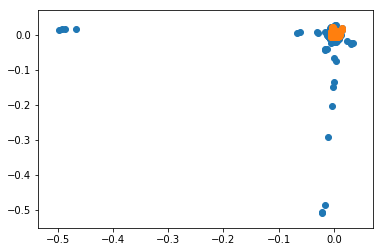

In [144]:
plt.scatter(pcs.pc1,pcs.pc2)
plt.scatter(tz_meta.pc1,tz_meta.pc2)

In [63]:
def super_model(m,X,y,val_idx,mr,pca=True,rcol=['gender','nationality']):
    #pca
    if pca:        
        pca = PCA(.95)
        X=pd.DataFrame(pca.fit_transform(X))
        print(X.shape)
    #data    
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[rcol].values, np.array(y.height))
    ((yb_val,yb_trn),(yt_val,yt_trn)) = split_by_idx(val_idx,y.biclass,y.triclass)
     
    tz_idx = boo2idx(y.gender==2)
    ((tz,os), (y_tz,y_os)) = split_by_idx(tz_idx, X.values, np.array(y.residual))
    ((gn_tz,gn_os),(gn_y_tz,gn_y_os)) = split_by_idx(tz_idx, y[rcol].values, np.array(y.height))
    ((yb_tz,yb_os),(yt_tz,yt_os)) = split_by_idx(tz_idx,y.biclass,y.triclass)
    print([x.shape for x in [trn,val,tz,os]])
    
    #sv_idx = boo2idx(gn_val[:,0]==2)
    #((val_f,val_m), (y_val_f,y_val_m)) = split_by_idx(sv_idx, val, y_val)
    #((gn_val_f,gn_val_m),(gn_y_val_f,gn_y_val_m)) = split_by_idx(sv_idx, gn_val, gn_y_trn)
    #((yb_val_f,yb_val_m),(yt_val_f,yt_val_m)) = split_by_idx(sv_idx,yb_val,yt_val)
    #model
    ml = m
    ml.fit(trn, y_trn)
    
    mb = linear_model.LogisticRegression()
    mb.fit(trn, yb_trn)
    
    mt = linear_model.LogisticRegression()
    mt.fit(trn, yt_trn)
    
    #
    yr = [y_trn,y_val,y_tz,y_os]
    yh = [gn_y_trn,gn_y_val,gn_y_tz,gn_y_os]
    yb = [yb_trn,yb_val,yb_tz,yb_os]
    yt = [yt_trn,yt_val,yt_tz,yt_os]
    gd = [gn_trn[:,0],gn_val[:,0],gn_tz[:,0],gn_os[:,0]]
    #pred
    pbase = model_pred(mr,[gn_trn,gn_val,gn_tz,gn_os])
    pr = model_pred(ml,[trn,val,tz,os])
    pbi = model_pred(mb,[trn,val,tz,os])
    pbi_prob = model_pred(mb,[trn,val,tz,os],p=True)
    ptri =  model_pred(mt,[trn,val,tz,os])
    ptri_prob = model_pred(mt,[trn,val,tz,os],p=True)
    ph = [x+y for x,y in zip(pr,pbase)]
    pr_c = [np.clip(x,-20,20) for x in pr]
    ph_c = [x+y for x,y in zip(pr_c,pbase)]
    pr_b = [biclip(x,b) for x,b in zip(pr_c,pbi)]
    ph_b = [x+y for x,y in zip(pr_b,pbase)]
    pr_t = [triclip(x,b,t) for x,b,t in zip(pr_c,pbi,ptri)]
    ph_t = [x+y for x,y in zip(pr_t,pbase)]
    
    fpr_b,tpr_b,auc_b=[],[],[]
    for y,scores in zip(yb,pbi_prob):
        #print(y,scores)
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        auc_b.append(metrics.auc(fpr, tpr))
        fpr_b.append(fpr)
        tpr_b.append(tpr)
    #print('auc_b',auc_b)
    fpr_t,tpr_t,auc_t=[],[],[]
    for y,scores in zip(yt,ptri_prob):
        fpr, tpr, _ = metrics.roc_curve(y, scores,pos_label=1)
        auc_t.append(metrics.auc(fpr, tpr))
        fpr_t.append(fpr)
        tpr_t.append(tpr)  
    #print('auc_t',auc_t)
    f, axs = plt.subplots(5, 4,figsize=(20, 16))
    axs = axs.ravel()
    for i,x,y,z in zip(list(range(12)),yh+yr+yh,ph+pr+pbi_prob,gd+gd+gd):
        #print(i,x,y)
        axs[i].scatter(x,y,marker='o',c=z)
    for i,x,y in zip(list(range(12,21)),fpr_b+fpr_t,tpr_b+tpr_t):
        axs[i].plot(x,y)
    plt.show()
    
    print(pd.DataFrame({
        'auc_b':auc_b,
        'auc_t':auc_t,
        'R2':[metrics.r2_score(x,y) for x,y in zip(yh,pbase)],
        'MSE':[metrics.mean_squared_error(x,y) for x,y in zip(yh,pbase)]
    },index=['trn','val','female','male']))
    
    R2 = pd.DataFrame.from_records([[metrics.r2_score(x,y) for x,y in zip(yr+yh,t)] 
           for t in [pr+ph,pr_c+ph_c,pr_b+ph_b,pr_t+ph_t]],index=['r','c','b','t'],
                                  columns=['rt','rv','rf','rm','ht','hv','hf','hm'])
    MSE = pd.DataFrame.from_records([[metrics.mean_squared_error(x,y) for x,y in zip(yr+yh,t)] 
           for t in [pr+ph,pr_c+ph_c,pr_b+ph_b,pr_t+ph_t]],index=['r','c','b','t'],
                                  columns=['rt','rv','rf','rm','ht','hv','hf','hm'])
    #max(ml.coef_),min(ml.coef_)
    return R2,MSE

In [ ]:
def train_model(m,X,y,val_idx,mr):
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))

    ml = m
    ml.fit(trn, y_trn)


    pr_trn = np.clip(ml.predict(trn),-20,20)
    ph_trn = mr.predict(gn_trn)+pr_trn
    pr_val = np.clip(ml.predict(val),-20,20)
    ph_val = mr.predict(gn_val)+pr_val
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(y_val,pr_val,c=gn_val[:,0], marker='o')
    ax3.scatter(gn_y_trn,ph_trn,c=gn_trn[:,1], marker='o')
    ax4.scatter(gn_y_val,ph_val,c=gn_val[:,1], marker='o')

    plt.title(n);
    plt.show()

    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,score)


In [176]:


def train_model(m,X,y,val_idx,mr):
    ((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, np.array(y.residual))
    ((gn_val,gn_trn),(gn_y_val,gn_y_trn)) = split_by_idx(val_idx, y[['gender','nationality']].values, np.array(y.height))
    ((yb_val,yb_trn),(yt_val,yt_trn)) = split_by_idx(val_idx,y.biclass,y.triclass)
         
    ml = m
    ml.fit(trn, y_trn)
    
    mb = linear_model.LogisticRegression()
    mb.fit(trn, yb_trn)
    
    mt = linear_model.LogisticRegression()
    mt.fit(trn, yt_trn)

    pr_trn = np.clip(ml.predict(trn),-20,20)
    ph_trn = mr.predict(gn_trn)+pr_trn
    pr_val = np.clip(ml.predict(val),-20,20)
    ph_val = mr.predict(gn_val)+pr_val
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(y_val,pr_val,c=gn_val[:,0], marker='o')
    ax3.scatter(gn_y_trn,ph_trn,c=gn_trn[:,1], marker='o')
    ax4.scatter(gn_y_val,ph_val,c=gn_val[:,1], marker='o')

    plt.title(n);
    plt.show()
    pb_val = mb.predict(val)
    pt_val = mt.predict(val)
    tmp=pd.DataFrame({'yb':yb_val,'yt':yt_val,'pb':pb_val,'pt':pt_val,'v':1})
    print(tmp.pivot_table(['v'],index=['yb'],columns=['pb'],aggfunc=np.sum))
    print(tmp.pivot_table(['v'],index=['yt'],columns=['pt'],aggfunc=np.sum))
    
    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    ax1.scatter(y_trn,pr_trn,c=gn_trn[:,0], marker='o')
    ax2.scatter(biclip(pr_val,pb_val,pt_val),pr_val,c=pt_val, marker='o')
    ax3.scatter(y_val,pr_val,c=pt_val, marker='o')
    ax4.scatter(y_val,biclip(pr_val,pb_val,pt_val),c=pt_val, marker='o')

    plt.title(n);
    plt.show()
    
    score=(ml.score(trn, y_trn), ml.score(val, y_val),
                  rsqure(pr_trn,y_trn),rsqure(pr_val,y_val),
                  rsqure(ph_trn,gn_y_trn),rsqure(ph_val,gn_y_val),
                  max(ml.coef_),min(ml.coef_))
    return (ml,mb,mt,score)

def topsnp_model(m,X,y,val_idx,mr,Xt,yt,topn=[500, 200, 100, 50, 20, 10]):
    score={}
    for n in topn: 
        var_idx = list(range(n))
        ml,mb,mt,score[n] = train_model(m,X.iloc[:,var_idx],y,val_idx,mr)
        ph_test = mr.predict(yt[['gender','nationality']].values)+biclip(np.clip(ml.predict(Xt.iloc[:,var_idx]),-20,20),mb.predict(Xt.iloc[:,var_idx]),mt.predict(Xt.iloc[:,var_idx]))
        challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
        challenge.submit(ph_test.tolist())
        challenge.disconnect()
    return pd.DataFrame(score)

## 2.SNPs from GWAS of TZ2014

# Build Model

## Data Prepare

In [10]:
all_bed_T = pd.read_pickle(TMP_PATH/'all_bed_T_top10000.pk')

In [165]:
sum(tmp.astype(np.float32))

783.0

In [276]:
X = all_bed_T
X['gender'] = pd.Series(list(all_meta.gender),index=X.index)
X['nationality'] = pd.Series(list((all_meta.nationality=='PROBLEM').astype(np.int)),index=X.index)
X.fillna(-1,inplace=True)
y = all_meta.height

df_test = os_sub_test_align.T
df_test['gender']=pd.Series(list(os_meta_test.SNPSEX[[int(x) for x in list(os_plink_test[1].iid)]]),index=df_test.index)
df_test['nationality'] = 1
#Replace nan values in the training and testing set with an arbitrary number (-1)
df_test.fillna(-1,inplace=True)

### Linear model for os data

## Sample seperation

3530 2647


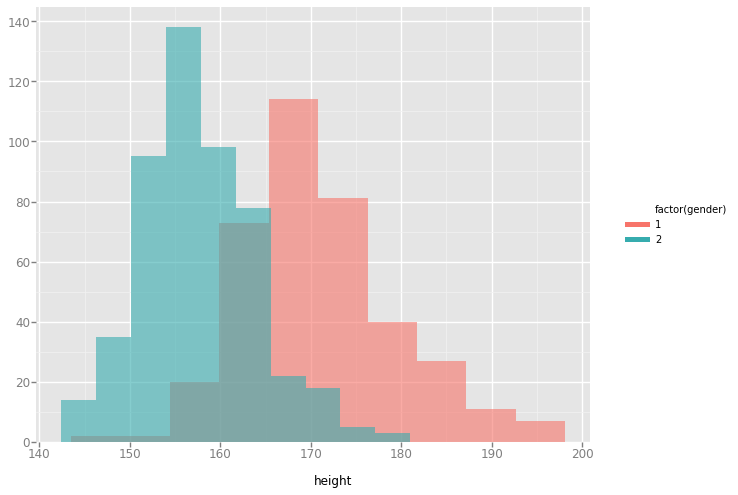

<ggplot: (-9223363300284316977)>

In [272]:
samp_size=len(all_meta)
train_ratio = 0.75
#train_ratio = 0.9
train_size = int(samp_size * train_ratio)

import random
val_idx = random.sample(range(samp_size), samp_size-train_size)
print(samp_size,train_size)
ggplot( aes(x='height',fill='factor(gender)'),data=all_meta.loc[val_idx]) +\
    geom_histogram(alpha=0.6)

## Random Forest

In [282]:
y = np.array(y)

In [283]:
from sklearn.ensemble import RandomForestRegressor
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, X.values, y)

m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [3]:
preds = m.predict(val)

NameError: name 'm' is not defined

In [285]:
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_

(0.8439407662079724, 0.11804699118137751, 0.0804589756030738)

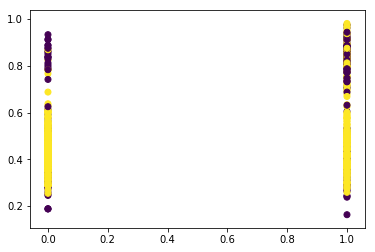

In [286]:
plt.scatter(y_val,preds,c=list(val[:,7726]), marker='o')

## NN1

In [ ]:
def NN_model()

In [85]:
def NN_Learner(meta,snp,tz_plink,ml=linear_model.LinearRegression(),regr=regr,pca=True):

    tz_snp_index = [i for i,x in enumerate(tz_plink[0].snp) if x in snp]
    tz_sample_index = [i for i,x in enumerate(tz_plink[1].iid) if x in list(meta.index)]
    tz_sub=plink_slice(tz_plink,tz_snp_index,tz_sample_index)
    
    all_bim = tz_sub[0]
    all_fam = tz_sub[1]
    all_bed_T= pd.DataFrame(tz_sub[2].compute()).T
    all_bed_T.fillna(-1,inplace=True)
    all_bed_T.index = list(all_fam.iid)
    all_bed_T.columns=list(all_bim.snp)
    print(all_bim.shape,all_fam.shape,all_bed_T.shape)
    
    samp_size=len(meta)
    train_ratio = 0.8
    train_size = int(samp_size * train_ratio)
    random.seed(1)
    val_idx = random.sample(range(samp_size), samp_size-train_size)
    print(samp_size,train_size)
    
    m=ml
    X = all_bed_T
    y = meta
    mr = regr
    
    m = nn_model(m,X,y,val_idx,mr,pca=pca)
    
    return m

In [89]:
def nn_model(m,X,y,val_idx,mr,pca=True):
    #pca
    if pca:        
        pca = PCA(.95)
        X=pd.DataFrame(pca.fit_transform(X))
        print(X.shape)
    #data
    X['gender']=pd.Series(list(y.gender),index=X.index)
    X['nationality']=pd.Series(list(y.nationality),index=X.index)
    #X=pd.concat([X, y[['gender','nationality']]], axis=1)
    print(X.shape)
    cat_vars = ['gender','nationality']
    y = y.residual
    md = ColumnarModelData.from_data_frame(PATH, val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=64)
    cat_sz = [('gender',3),('nationality',2)]
    print(cat_sz)
    emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
    print(emb_szs)

    y_range = (130,210)

    m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                       0, 1, [256,128,64], [0.5,0.3,0])
    lr = 1e-3
    m.lr_find()
    m.sched.plot()
    m.fit(lr, 3,metrics=[metrics.r2_score,metrics.mean_squared_error], cycle_len=10)
    return m

(500, 7) (2747, 7) (2747, 500)
2747 2197
(2747, 502)
[('gender', 3), ('nationality', 2)]
[(3, 2), (2, 1)]


 49%|████▊     | 17/35 [00:00<00:00, 167.80it/s, loss=39.4]


epoch      trn_loss   val_loss   r2_score   mean_squared_error 
    0      38.028437  35.135227  -735.063737 35.135228 
    1      33.71138   34.47172   -1565.72258 34.47172      
    2      32.159708  33.690207  -871.400868 33.690208     
    3      30.947124  32.703393  -284.170785 32.703393     
    4      29.949424  31.386429  -80.745528 31.386429      
    5      29.236139  29.796558  -37.720747 29.796559      
    6      28.052936  27.927441  -15.866077 27.92744       
    7      27.03096   27.278334  -12.102844 27.278334      
    8      26.131695  26.904948  -10.335055 26.904948      
    9      25.499191  26.894388  -10.233735 26.894389      
    10     25.515028  26.544644  -7.021991  26.544643      
    11     25.081487  23.920877  -4.066026  23.920877      
    12     23.449426  24.228447  -4.866455  24.228446      
    13     22.65313   22.989453  -3.305938  22.989453      
    14     21.610464  21.75661   -1.915976  21.756611      
    15     20.871992  21.604129  -1.3552

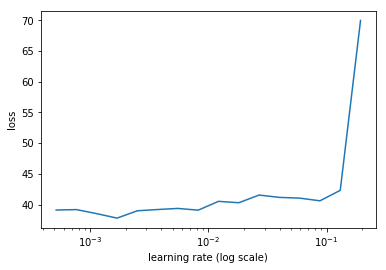

In [91]:
m=NN_Learner(tz_meta,snp_list[4]['tz_a'],tz_plink,pca=False)

In [1]:
cat_vars = ['gender','nationality']

md = ColumnarModelData.from_data_frame(PATH, val_idx, X, y.astype(np.float32), cat_flds=cat_vars, bs=128)
cat_sz = [('gender':3,'nationality':2)]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

y_range = (130,210)

m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [128,64,16], [0,0.1,0.1])
lr = 1e-3
m.lr_find()
m.sched.plot()
m.fit(lr, 3, cycle_len=3)

NameError: name 'X' is not defined

In [198]:
#m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
#                   0, 1, [256,128,64], [0.3,0.5,0.3], y_range=y_range)

In [213]:
m = md.get_learner(emb_szs, len(X.columns)-len(cat_vars),
                   0, 1, [128,64,16], [0,0.1,0.1])

lr = 1e-3
m.lr_find()
m.sched.plot()
m.fit(lr, 3, cycle_len=3)

In [230]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      56.733091  62.744966 
    1      49.164127  62.002885                            
    2      44.179577  61.256397                          
    3      42.012801  60.872404                            
    4      39.967664  60.322566                          
    5      43.533669  60.629964                            
    6      42.154946  58.021469                          
    7      41.29138   57.008608                          
    8      40.034128  56.676835                          
    9      40.916238  60.169139                            



[array([60.16914])]

In [983]:
m.save('nn_model1') #R2=0.355

 24%|██▍       | 12/50 [00:00<00:00, 119.82it/s, loss=43.2]

epoch      trn_loss   val_loss                             
    0      80.888028  151.194055



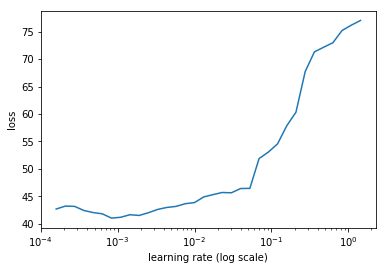

In [984]:
m.lr_find()
m.sched.plot()

In [985]:
m.fit(0.01, 3, cycle_len=1)

epoch      trn_loss   val_loss                             
    0      50.995664  42.544632 
    1      43.480691  41.338056                            
    2      42.126355  41.464497                            



[array([41.4645])]

In [1026]:
m.fit(lr, 10, cycle_len=1)

epoch      trn_loss   val_loss                            
    0      57.78584   49.578513 
    1      53.775634  46.085355                            
    2      51.614049  43.825487                            
    3      50.302809  40.732563                            
    4      49.565065  43.737697                           
    5      47.954103  40.983987                            
    6      47.264173  38.763312                          
    7      46.305101  38.572067                            
    8      45.49319   38.968085                            
    9      46.022123  39.092998                            



[array([39.093])]

In [987]:
m.save('nn_model2') #R2=0.436

In [9]:
m.load('nn_model2')

NameError: name 'm' is not defined

In [231]:
# Predict the heights for the test set
heights = m.predict(True)
heights=heights.reshape(137)
heights = heights.tolist()
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : adf40834-afd7-4b4d-bb1d-a0116c14b777


  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : adf40834-afd7-4b4d-bb1d-a0116c14b777


100% |██████████|[00:00<00:00]  109.49% /s] 


CrowdAI.Event.Job.INFO : (adf40834-afd7-4b4d-bb1d-a0116c14b777) Scores Submitted Successfully ! Coefficient of Determination(R^2) : 0.073840333075 ; MSE : 94.1487447856
CrowdAI.Event.Job.COMPLETE : adf40834-afd7-4b4d-bb1d-a0116c14b777	   🍺 


## NN2

In [972]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(y)
y_range = (140,200)

In [317]:
maf=pd.read_csv('../predict_height/lib/maf.csv',index_col=0)

In [321]:
sum([x in maf.index for x in all_bim.snp])

628

In [792]:
# Instantiate a linear model
x_train=X
y_train=y
x_test=df_test
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Predict the heights for the test set
heights = regr.predict(x_test)

In [793]:
#Convert heights from np.array to a list (to ensure it is JSON serializable)
challenge = crowdai.Challenge("OpenSNPChallenge2017", "02f5a9824254b85a068fbdfbb1298b8e")

heights = heights.tolist()
challenge.submit(heights)
challenge.disconnect()

CrowdAI.Event.Authentication : Authenticating for challenge = OpenSNPChallenge2017
CrowdAI.Event.Connection.CONNECTED



  0% |          |[00:00<?]  ?% /s] 

CrowdAI.Event.Authentication.SUCCESS : Authentication Successful



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.ENQUEUED : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 

CrowdAI.Event.Job.RUNNING : bc1ef311-9598-4a6c-a9a2-cce75662d779



          
  0% |          |[16:49<?]  ?% /s] 
100% |██████████|[00:00<00:00]  102.69% /s] 
          
  0% |          |[16:49<?]  ?% /s] .69% /s] 


CrowdAI.Event.Job.INFO : (bc1ef311-9598-4a6c-a9a2-cce75662d779) Scores Submitted Successfully ! Coefficient of Determination(R^2) : -0.0365818509984 ; MSE : 105.373709981
CrowdAI.Event.Job.COMPLETE : bc1ef311-9598-4a6c-a9a2-cce75662d779	   🍺 


In [ ]:
import preprocess
import argparse
import models


def init_args():
    parser = argparse.ArgumentParser(description='Train and save models')
    parser.add_argument('train_datesets', help='Input csv file for training output from parse_inputs.py')
    parser.add_argument('-m', '--model', help='Train model, comma to separate', default='gbr')
    parser.add_argument('-d', '--model-dir', help='Model directory', default='models')
    parser.add_argument('-l', '--list-models', help='List available models', action='store_true')
    args = parser.parse_args()
    return args


def main():
    args = init_args()
    if args.list_models:
        print('\n'.join(models.get_model_names()))
        exit()
    m = args.model.split(',')
    dict_m = models.get_models(m)
    x, y = preprocess.load_data(args.train_datesets)
    for model_name in dict_m:
        model = dict_m[model_name]
        print('Training model %s' % model_name)
        model.fit(x, y)
        models.save_model(model, model_name, args.model_dir)
        print('Train finished, save to %s' % args.model_dir)

